In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import sys
import math
sys.path.append('..')

from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn

import sys
sys.path.append('../')
from models import toynet
from evolutions import *
from utils import stack_imgs
from evaluation import solve_ode, solve_ode_rk
from train import loss_AM

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

## Define evolution

SIMPLE corresponds to
$$q_t = \mathcal{N}\bigg(x_t|x_0\sqrt{1-t},t\mathbf{I})\bigg)$$
VPSDE corresponds to
$$q_t = \mathcal{N}\bigg(x_t|x_0e^{-\frac{1}{2}\int dt'\;\beta(t')},\mathbf{I}(1-e^{-\int dt'\;\beta(t')})\bigg)$$
sub-VPSDE corresponds to
$$q_t = \mathcal{N}\bigg(x_t|x_0e^{-\frac{1}{2}\int dt'\;\beta(t')},\mathbf{I}(1-e^{-\int dt'\;\beta(t')})^2\bigg)$$

In [3]:
device = torch.device('cuda')

q_t = vpsde

data_samples = 2000
data = torch.randn([data_samples,1]) + 2
data = torch.vstack([data, torch.randn([data_samples,1]) - 2])
data = data/data.std()
data = data.to(device)

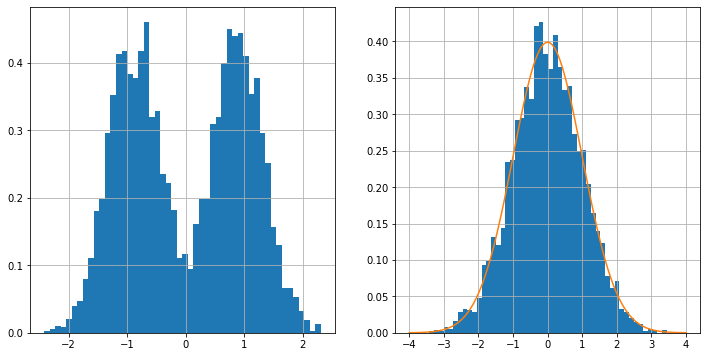

In [4]:
figsize(12,6)
plt.subplot(121)
plt.hist(data.cpu().numpy(), bins=50, density=True)
plt.grid()

x_1 = q_t(data, torch.ones([data.shape[0],1]).to(device))
plt.subplot(122)
plt.hist(x_1.cpu().numpy(), bins=50, density=True)
x = np.linspace(-4,4,100)
plt.plot(x, np.exp(-0.5*x**2)/math.sqrt(2*math.pi))
plt.grid()

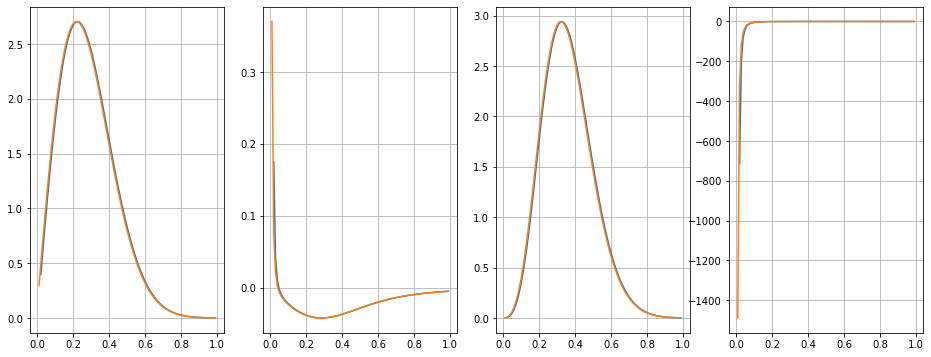

In [5]:
figsize(16,6)
dt = 1e-2
t = torch.arange(1e-2,1.0,dt)
plt.subplot(141)
plt.plot(t[1:], np.diff(w1(t).numpy())/dt)
plt.plot(t, dw1dt(t).numpy())
plt.grid()
plt.subplot(142)
plt.plot(t[1:], np.diff(w2(t).numpy())/dt)
plt.plot(t, dw2dt(t).numpy())
plt.grid()
plt.subplot(143)
plt.plot(t[1:], np.diff(w3(t).numpy())/dt)
plt.plot(t, dw3dt(t).numpy())
plt.grid()
plt.subplot(144)
plt.plot(t[1:], np.diff(w4(t).numpy())/dt)
plt.plot(t, dw4dt(t).numpy())
plt.grid()

## Learning the potential

$$\int dx\;dt\;q_t\omega_t\bigg[\frac{1}{2}\Vert\nabla s\Vert^2 + \frac{\partial s}{\partial t}\bigg] + \int dx\;dt\; q_ts\frac{\partial \omega_t}{\partial t} - \int dx\;\bigg[ q_1\omega_1s_1 - q_0\omega_0s_0\bigg] \to \min_s$$

In [22]:
import scipy.interpolate


# class AdaptiveLoss:
#     def __init__(self, t0=0.0, t1=1.0, n=200, alpha=1e-2, beta=0.99):
#         self.t0, self.t1 = t0, t1
#         self.alpha, self.beta = alpha, beta
#         self.timesteps = np.linspace(t0, t1, n)
#         self.dt = (t1-t0)/(n-1)
#         self._update_w(np.ones_like(self.timesteps))
        
#     def _update_w(self, w):
#         dt, t = self.dt, self.timesteps
#         w = w/(w.sum()*dt - w[0]*dt/2 - w[-1]*dt/2)
#         self.w = w
#         self.fw = scipy.interpolate.interp1d(t, w, kind='nearest')
#         mass = np.concatenate([np.zeros([1]), w[:1]*dt/2, w[0]*dt/2 + w[1:-1].cumsum()*dt, np.ones([1])])
#         grid = np.concatenate([self.t0*np.ones([1]), t[:-1] + dt/2, self.t1*np.ones([1])])
#         self.F_inv = scipy.interpolate.interp1d(mass, grid, kind='linear')
        
#     def sample_t(self, n, device):
#         u = (np.random.uniform() + np.sqrt(2)*np.arange(n)) % 1
#         t_samples = self.F_inv(u)
#         w_t = self.fw(t_samples)
#         t_samples = torch.from_numpy(t_samples).to(device).float()
#         w_t = torch.from_numpy(w_t).to(device).float()
#         return t_samples, w_t
    
#     def update_w(self, new_w, t):
#         new_w, t = new_w.cpu().numpy().flatten(), t.cpu().numpy().flatten()
#         weights = np.exp(-np.abs(self.timesteps.reshape(-1, 1) - t.reshape(1,-1))*1e2)
#         weights = weights/weights.sum(1,keepdims=True)
#         w = self.beta*(self.w-self.alpha*(self.t1-self.t0)) + (1-self.beta)*weights@new_w
#         w = (1.0-self.alpha)*w/(w.sum()*self.dt)+self.alpha*(self.t1-self.t0)
#         self._update_w(w)
        
#     def get_loss(self, s, x, q_t):
#         t_0, t_1 = self.t0, self.t1
#         device = x.device
#         bs = x.shape[0]
#         t, w_t = self.sample_t(bs, device)
#         while (x.dim() > t.dim()): t = t.unsqueeze(-1)
#         x_t = q_t(x, t)
#         x_t.requires_grad, t.requires_grad = True, True
#         s_t = s(t, x_t)
#         dsdt, dsdx = torch.autograd.grad(s_t.sum(), [t, x_t], create_graph=True, retain_graph=True)
#         x_t, t = x_t.detach(), t.detach()

#         t_0 = t_0*torch.ones(bs).to(device)
#         x_0 = q_t(x, t_0)

#         t_1 = t_1*torch.ones(bs).to(device)
#         x_1 = q_t(x, t_1)

#         dims_to_reduce = [i + 1 for i in range(x.dim()-1)]
#         loss = (0.5*(dsdx**2).sum(dims_to_reduce) + dsdt.sum(dims_to_reduce))/w_t
#         loss = loss*(t_1-t_0).squeeze()
#         loss = loss + (-s(t_1,x_1).squeeze() + s(t_0,x_0).squeeze())
        
#         time_loss = torch.abs(0.5*(dsdx**2).sum(dims_to_reduce) + dsdt.sum(dims_to_reduce)).detach()
#         self.update_w(time_loss, t)
#         return loss.mean()

class AdaptiveLoss:
    def __init__(self, t0=0.0, t1=1.0, n=100, alpha=1.0, beta=0.99):
        self.t0, self.t1 = t0, t1
        self.alpha, self.beta = alpha, beta
        self.timesteps = np.linspace(t0, t1, n)
        self.dt = (t1-t0)/(n-1)
        self._update_w(np.ones_like(self.timesteps))
        
    def _update_w(self, w):
        dt, t = self.dt, self.timesteps
        w = w/((w[1:]+w[:-1])*dt/2).sum()
        self.w = w
        self.fw = scipy.interpolate.interp1d(t, w, kind='linear')
        self.dwdt = scipy.interpolate.interp1d(t, np.concatenate([w[1:]-w[:-1], w[-1:]-w[-2:-1]])/dt, kind='zero')
        intercept = lambda t: self.fw(t)-self.dwdt(t)*t
        t0_interval = scipy.interpolate.interp1d(t, t, kind='zero')
        mass = np.concatenate([np.zeros([1]), ((w[1:]+w[:-1])*dt/2).cumsum()])
        F0_interval = scipy.interpolate.interp1d(t, mass, kind='zero')
        F0_inv = scipy.interpolate.interp1d(mass, t, kind='zero')
        def F(t):
            t0_ = t0_interval(t)
            F0_ = F0_interval(t)
            k, b = self.dwdt(t), intercept(t)
            output = 0.5*k*(t**2-t0_**2) + b*(t-t0_)
            return F0_ + output 

        def F_inv(y):
            t0_ = F0_inv(y)
            F0_ = F0_interval(t0_)
            k, b = self.dwdt(t0_), intercept(t0_)
            c = y - F0_
            c = c + 0.5*k*t0_**2 + b*t0_
            D = np.sqrt(b**2 + 2*k*c)
            output = (-b + D) * (np.abs(k) > 0)  + c/b * (np.abs(k) == 0.0)
            output[np.abs(k) > 0] /= k[np.abs(k) > 0]
            return output
        
        self.F_inv = F_inv
        
#     def sample_t(self, n, device):
#         u = (np.random.uniform() + np.sqrt(2)*np.arange(n)) % 1
#         t_samples = self.F_inv(u)
#         w_t = self.fw(t_samples)
#         t_samples = torch.from_numpy(t_samples).to(device).float()
#         w_t = torch.from_numpy(w_t).to(device).float()
#         return t_samples, w_t

    def sample_t(self, n, device):
        u = (np.random.uniform() + np.sqrt(2)*np.arange(n)) % 1
#         t = u*(self.t1-self.t0) + self.t0
        t = self.F_inv(u)
        w_t, dwdt = self.fw(t), self.dwdt(t)
        w_0, w_1 = self.fw(self.t0*np.ones_like(t)), self.fw(self.t1*np.ones_like(t))
        t = torch.from_numpy(t).to(device).float()
        w_t, dwdt = torch.from_numpy(w_t).to(device).float(), torch.from_numpy(dwdt).to(device).float()
        w_0, w_1 = torch.from_numpy(w_0).to(device).float(), torch.from_numpy(w_1).to(device).float()
        return t, w_t, dwdt, w_1, w_0
    
    def update_w(self, new_w, t):
        new_w, t = new_w.cpu().numpy().flatten(), t.cpu().numpy().flatten()
        weights = np.exp(-np.abs(self.timesteps.reshape(-1, 1) - t.reshape(1,-1))*1e2)
        weights = weights/weights.sum(1,keepdims=True)
#         w = self.beta*(self.w-self.alpha*(self.t1-self.t0)) + (1-self.beta)*np.sqrt(weights@(new_w**2))
        w = self.beta*(self.w-self.alpha*(self.t1-self.t0)) + (1-self.beta)*weights@new_w
        w = (1.0-self.alpha)*w/(w.sum()*self.dt)+self.alpha*(self.t1-self.t0)
        self._update_w(w)
        
    def get_loss(self, s, x, q_t):
        t_0, t_1 = self.t0, self.t1
        device = x.device
        bs = x.shape[0]
        t, w_t, dwdt, w_1, w_0 = self.sample_t(bs, device)
        while (x.dim() > t.dim()): t = t.unsqueeze(-1)
        x_t = q_t(x, t)
        x_t.requires_grad, t.requires_grad = True, True
        s_t = s(t, x_t)
        dsdt, dsdx = torch.autograd.grad(s_t.sum(), [t, x_t], create_graph=True, retain_graph=True)
        x_t, t = x_t.detach(), t.detach()

        t_0 = t_0*torch.ones(bs).to(device)
        x_0 = q_t(x, t_0)

        t_1 = t_1*torch.ones(bs).to(device)
        x_1 = q_t(x, t_1)

        dims_to_reduce = [i + 1 for i in range(x.dim()-1)]
        loss = (0.5*(dsdx**2).sum(dims_to_reduce) + dsdt.sum(dims_to_reduce))/w_t
        loss = loss.squeeze()# + s_t.squeeze()*dwdt
        loss = loss*(t_1-t_0).squeeze()
#         loss = loss + (-s(t_1,x_1).squeeze()*w_1 + s(t_0,x_0).squeeze()*w_0)
        loss = loss + (-s(t_1,x_1).squeeze() + s(t_0,x_0).squeeze())
        
#         time_loss = (0.5*(dsdx**2).sum(dims_to_reduce) + torch.abs(dsdt.sum(dims_to_reduce))).detach()
        time_loss = (0.5*(dsdx**2).sum(dims_to_reduce)).detach()
        self.update_w(time_loss, t)
        return loss.mean()

In [22]:
n=10
t = np.linspace(0,1,n)
dt = (1-0)/(n-1)
w = (t-0.5)**2
w = w/(w.sum()*dt - w[0]*dt/2 - w[-1]*dt/2)
f = scipy.interpolate.interp1d(t, w, kind='nearest')
square = np.concatenate([np.zeros([1]), w[:1]*dt/2, w[0]*dt/2 + w[1:-1].cumsum()*dt, np.ones([1])])
grid = np.concatenate([np.zeros([1]), t[:-1] + dt/2, np.ones([1])])
F_inv = scipy.interpolate.interp1d(square, grid, kind='linear')

In [138]:
n=10
t = np.linspace(0,1,n)
dt = (1-0)/(n-1)
w = (t-0.5)**2
w = w/((w[1:]+w[:-1])*dt/2).sum()
f = scipy.interpolate.interp1d(t, w, kind='linear')
dfdt = scipy.interpolate.interp1d(t, np.concatenate([w[1:]-w[:-1], w[-1:]-w[-2:-1]])/dt, kind='zero')
intercept = lambda t: f(t)-dfdt(t)*t
t0_interval = scipy.interpolate.interp1d(t, t, kind='zero')
mass = np.concatenate([np.zeros([1]), ((w[1:]+w[:-1])*dt/2).cumsum()])
F0_interval = scipy.interpolate.interp1d(t, mass, kind='zero')
F0_inv = scipy.interpolate.interp1d(mass, t, kind='zero')
def F(t):
    t0_ = t0_interval(t)
    F0_ = F0_interval(t)
    k, b = dfdt(t), intercept(t)
    output = 0.5*k*(t**2-t0_**2) + b*(t-t0_)
    return F0_ + output 

def F_inv(y):
    t0_ = F0_inv(y)
    F0_ = F0_interval(t0_)
    k, b = dfdt(t0_), intercept(t0_)
    c = y - F0_
    c = c + 0.5*k*t0_**2 + b*t0_
    D = np.sqrt(b**2 + 2*k*c)
    output = (-b + D) * (np.abs(k) > 0)  + c/b * (np.abs(k) == 0.0)
    output[np.abs(k) > 0] /= k[np.abs(k) > 0]
    return output

In [139]:
u = np.sqrt(2)*np.arange(11000) % 1

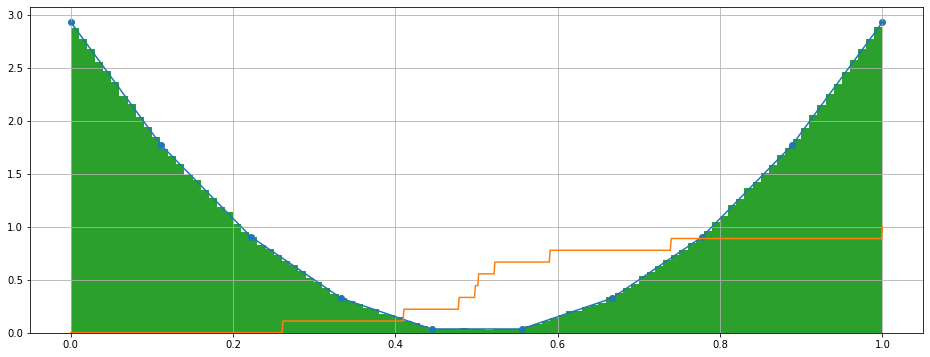

In [140]:
plt.plot(np.linspace(0,1,1000), f(np.linspace(0,1,1000)))
plt.plot(np.linspace(0,1,1000), F0_inv(np.linspace(0,1,1000)))
plt.hist(F_inv(u), density=True, bins=100)
plt.scatter(t, w)
plt.grid()

In [23]:
net = toynet.SmallMLP().to(device)
s, w, dwdt = get_s(net, 'generic'), w0, dw0dt
loss_AM = AdaptiveLoss()

In [24]:
torch.manual_seed(1)

optimizer = optim.Adam(net.parameters(), lr=1e-4, betas=(.9, .999))
n_iter = 10000
n_samples = 512
losses = np.zeros(n_iter)
for i in range(n_iter):
    for p in net.parameters(): p.grad = None
    
    x = data[torch.randperm(data.shape[0])[:n_samples]]
    loss = loss_AM.get_loss(s, x, q_t)
    loss.backward()
    optimizer.step()
    losses[i] = loss.detach().cpu().numpy()
    if (i % 2000) == 0:
        print('iteration: %d, loss: %.3e' % (i,losses[i]))

iteration: 0, loss: -8.619e-04
iteration: 2000, loss: -7.418e-02
iteration: 4000, loss: -5.064e-02
iteration: 6000, loss: -8.988e-02
iteration: 8000, loss: -5.129e-02


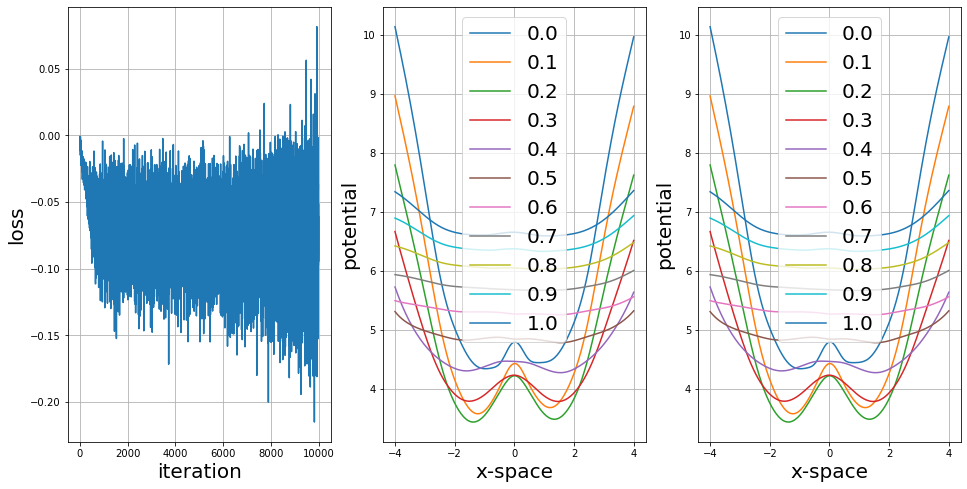

In [25]:
fs = 20

figsize(16,8)
plt.subplot(131)
plt.plot(losses)
plt.xlabel('iteration', fontsize=fs)
plt.ylabel('loss', fontsize=fs)
plt.grid()
plt.subplot(132)
n_points = 200
for i in range(11):
    x = torch.linspace(-4,4,n_points).view(-1,1).to(device)
    t = i/10*torch.ones([n_points,1]).to(device)
    plt.plot(x.cpu().numpy(), s(t,x).detach().cpu().numpy(), label='%.1f' % (i/10))
plt.xlabel('x-space', fontsize=fs)
plt.ylabel('potential', fontsize=fs)
plt.legend(fontsize=fs)
plt.grid()
plt.subplot(133)
n_points = 200
for i in range(11):
    x = torch.linspace(-4,4,n_points).view(-1,1).to(device)
    t = i/10*torch.ones([n_points,1]).to(device)
    plt.plot(x.cpu().numpy(), net(t,x).detach().cpu().numpy(), label='%.1f' % (i/10))
plt.xlabel('x-space', fontsize=fs)
plt.ylabel('potential', fontsize=fs)
plt.legend(fontsize=fs)
plt.grid()

In [26]:
times = torch.linspace(0,1,100).to(device)
kinetic = torch.zeros_like(times).cpu()
time_der = torch.zeros_like(times).cpu()
for i,t in enumerate(times):
    x_t = q_t(data[:500], t)
    vec_t = t*torch.ones_like(x_t)
    x_t.requires_grad, vec_t.requires_grad = True, True
    dsdx, dsdt = torch.autograd.grad(s(vec_t, x_t).sum(), [x_t, vec_t])
    dsdx, dsdt = dsdx.detach(), dsdt.detach()
    kinetic[i] = 0.5*(dsdx**2).sum(1).mean().cpu()
#     time_der[i] = torch.abs(dsdt).mean().cpu()
    time_der[i] = torch.abs(0.5*(dsdx**2).sum(1) + dsdt.sum(1)).mean().cpu()

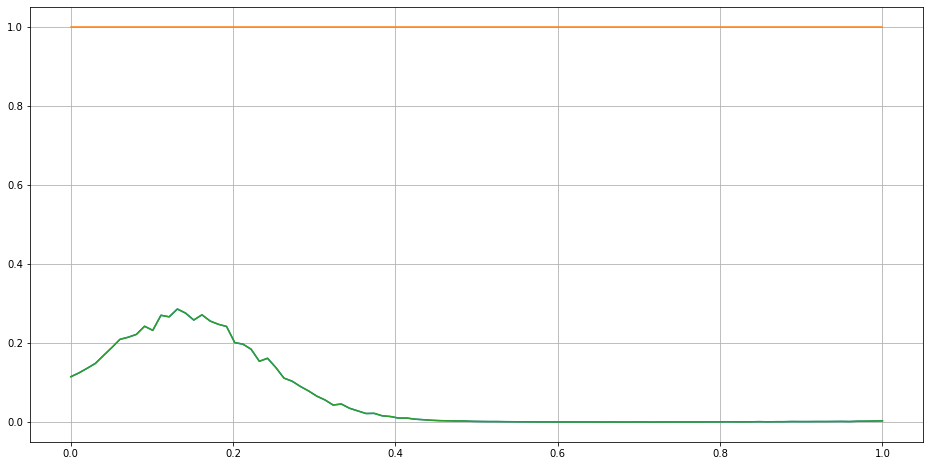

In [27]:
plt.plot(times.cpu(), kinetic)
plt.plot(times.cpu(), loss_AM.fw(times.cpu()))
plt.plot(times.cpu(), kinetic/loss_AM.fw(times.cpu()))
plt.grid()

## Generation

In [45]:
n_samples = 4000
x_1 = torch.randn([n_samples,1]).to(device)
x_0, nfe = solve_ode_rk(device, s, x_1)

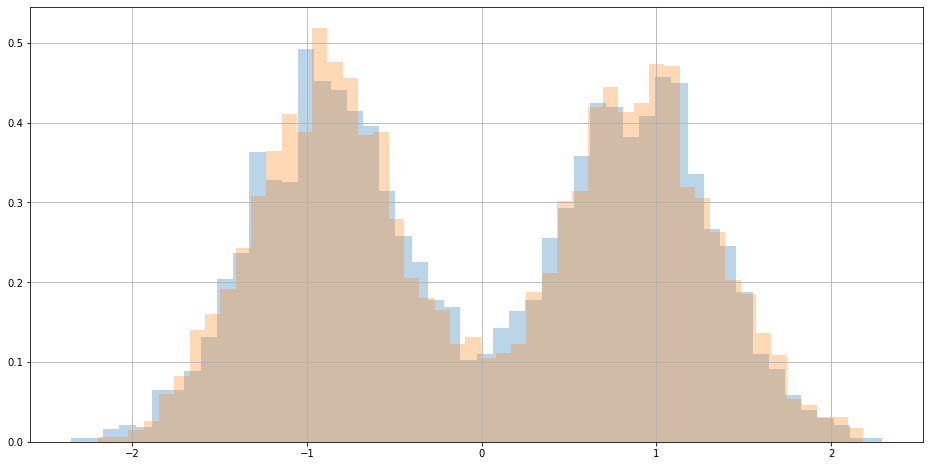

In [46]:
plt.hist(data.cpu().numpy().flatten(), bins=50, density=True, alpha=0.3)
plt.hist(x_0.cpu().numpy().flatten(), bins=50, density=True, alpha=0.3)
plt.grid()

## GIF

In [14]:
n_samples = 4000
x_1 = torch.randn([n_samples,1]).to(device)
frame_ids = list(range(1000))[::5]
frame_ids.append(999)
x_0, x_inter, t_inter = solve_ode(device, s, x_1, frame_ids)

In [27]:
for i in range(len(x_inter)):
    x_t, t = x_inter[i], t_inter[i]
    plt.subplot(121)
    plt.hist(x_t.cpu().numpy().flatten(), bins=40, alpha=0.4, 
             density=True, label=r'$q_{%.3f}$' % t)
    plt.hist(data.cpu().numpy().flatten(), bins=40, alpha=0.4, 
             density=True, label='target')
    plt.xlim(-3,3)
    plt.ylim(0.0,0.5)
    plt.legend(fontsize=fs, loc='upper right')
    plt.grid()

    plt.subplot(122)
    x_plot = torch.linspace(-8,8,n_points).view(-1,1).to(device)
    t_plot = t*torch.ones([n_points, 1]).to(device)
    plt.plot(x_plot.cpu().numpy(), s(t_plot,x_plot).detach().cpu().numpy(), 
             label='%.3f' % t)
    plt.plot()
    plt.ylim(4,9)
    plt.xlim(-3,3)
    plt.legend(fontsize=fs, loc='upper right')
    plt.grid()
    plt.savefig('gifs/simple/%.3d.png' % i, bbox_inches='tight')
    plt.clf()

<Figure size 1152x576 with 0 Axes>

In [28]:
!convert -delay 10 -loop 0 ./gifs/simple/*.png ./gifs/simple.gif